# Cosine similarity

**Goal:** Look at the cosine similarity of the slots to vizualize the failure cases going to "bad" minima for the poor reconstruction cases. (See one of these poor reco examples figures below.)

<img src="code/figures/learn-init-warm/loss-slots-iter42250-evt0.jpg" />

**Lukas's suggestion:** To diagnose this, let's look at the **cosine similarity** between the slots. E.g, for the "poor slot" reconstruction, basically we have two slots that are equally explaining each of the ring's pixels.


<img src="latent-img.png" style="height:300px"  />

Then, if we pick a different perturbation for the inputs... do we reconstruct the slots _better_?

<img src="reinit1.png" style="height:150px" />

<img src="reinit2.png" style="height:150px" />

**Plan:** I'll look at my "current best" model, training H=16, Q=128 with learnable initialization for the slots, where I started from a warm start.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SlotAttentionPosEmbed

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

**Load in the model**

In [3]:
from model import SoftPositionalEmbed, build_grid
from torch.nn import init

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [4]:
cID_prev = 'learn-init-warm2'
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cpu'}

In [5]:
m = SlotAttentionPosEmbed(**hps)

In [6]:
cID_prev
# weightPath = 'code/models/learn-init-warm/m_44000.pt'

lastIter = 400_000
weightPath = f'code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 400000


<All keys matched successfully>

**Create a test dataset**

In [7]:
kwargs = cd['data']
kwargs

{'N_clusters': 2, 'isRing': True}

**Sanity check:** What's the loss for this model? (Should be close to 0.02)

In [8]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [9]:
def get_loss(m,X,mask,return_mean=True):

    with torch.no_grad():

        queries, att, wts = m(X)

        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        
        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
        
        indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)

    if return_mean:
        return loss.mean().item()
    else:
        # just avg the pixel loss, but don't avg over the exs
        return loss.mean(axis=-1)

In [10]:
bs = 100

X,y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [11]:
losses = []

for i in range(0,1000_000,1_000):
    weightPath = f'code/models/{cID_prev}/m_{i}.pt'
    m.load_state_dict(torch.load(weightPath,map_location=device))
    
    loss = get_loss(m,X,mask)
    
    losses.append(loss)

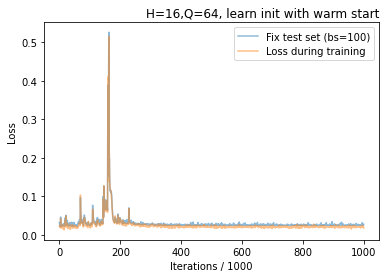

In [12]:
with open(f'code/models/{cID_prev}/loss.json') as f:
    ld = json.load(f)

plt.plot(losses,label=f'Fix test set (bs={bs})',alpha=.5)
plt.plot(ld[::1000],label=f'Loss during training',alpha=.5)
plt.xlabel('Iterations / 1000')
plt.ylabel('Loss')
plt.legend()
plt.title('H=16,Q=64, learn init with warm start',loc='right')
plt.show()

To me, this is already super interesting (and encouraging) that if the loss is high _it actually seems like it was coming from the model weights_

**How would this be promising?** This might be a good motivation for _gradient clipping_ b/c there were some steps that sent the model to a not great place.

**Look at some figures**

In [13]:
loss_ex = get_loss(m,X,mask,return_mean=False)

In [14]:
len(loss_ex)

100

Text(0.5, 0, 'Loss per example')

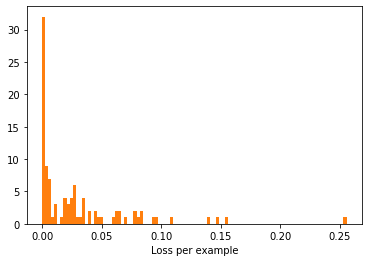

In [15]:
plt.hist(loss_ex.numpy(),100,color='C1')
plt.xlabel('Loss per example')

Example i=0 has loss 0.060


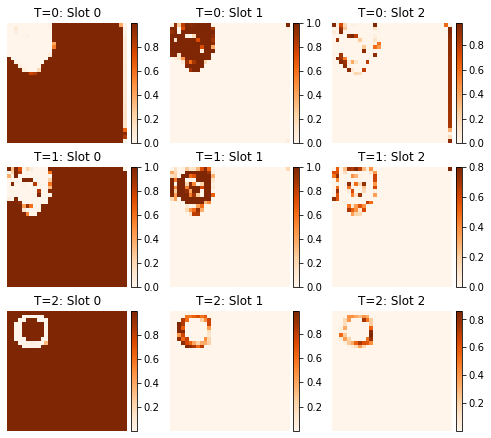

Example i=1 has loss 0.005


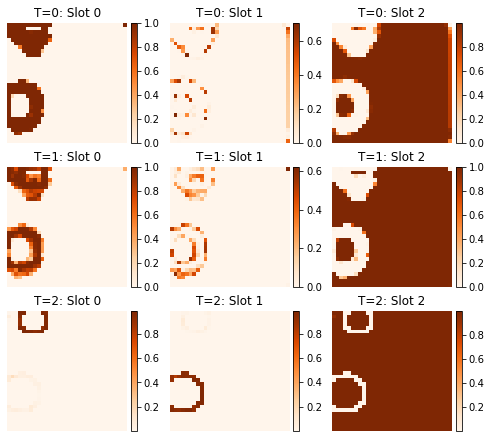

Example i=2 has loss 0.062


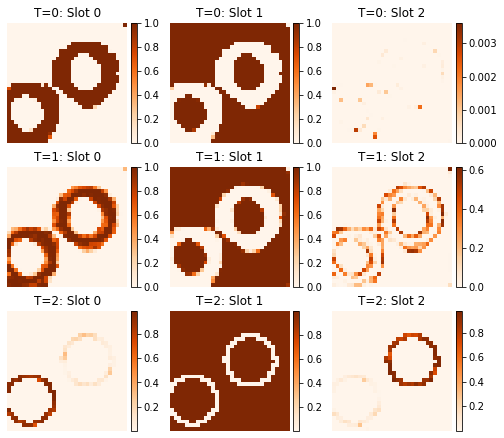

Example i=3 has loss 0.007


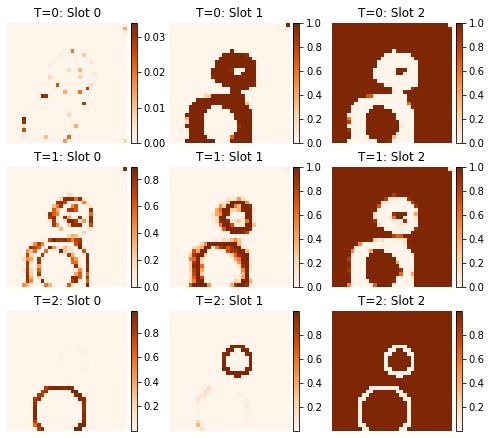

Example i=4 has loss 0.026


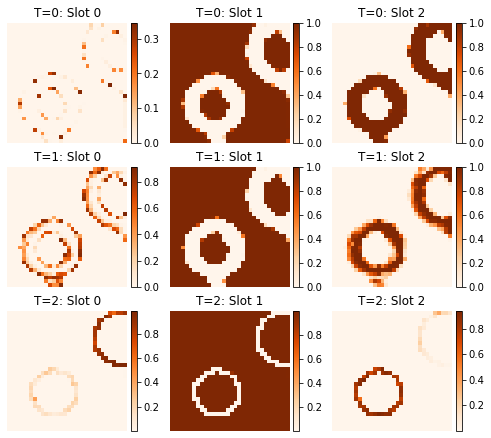

In [16]:
for i,li in zip(range(5),loss_ex):
    print(f'Example i={i} has loss {li.item():.3f}')
    
    plot_kslots_iters(m, X, iEvt=i,cmap='Oranges', showImg=True)
    

Super interesting... it seems like the examples are either _perfectly classified_ or not, there's not a lot of "in between" 

Let's look at the "worst loss".

In [17]:
i_max = loss_ex.argmax()
i_max

tensor(5)

In [18]:
loss_ex[i_max]

tensor(0.2557)

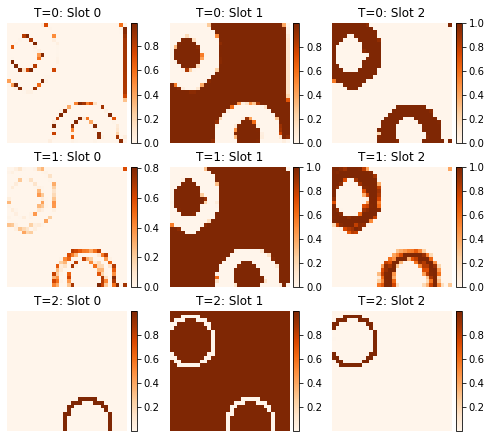

In [19]:
plot_kslots_iters(m, X, iEvt=i_max,cmap='Oranges', showImg=True)

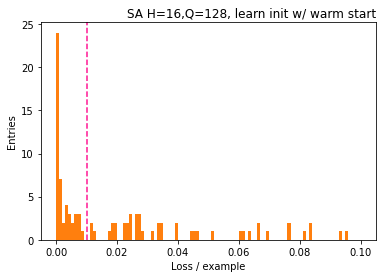

In [20]:
r = (0,.1)
plt.hist(loss_ex.numpy(),100,r,color='C1')
plt.xlabel('Loss / example')
plt.ylabel('Entries')
plt.title('SA H=16,Q=128, learn init w/ warm start',loc='right')

ylim = plt.ylim()
plt.plot([0.01]*2,ylim,'deeppink',ls='--')
plt.ylim(ylim)

plt.show()

**Look at cosine similarity:**
1. Between each slot and each image
2. Between each of the slots

^ I think I'm most interested in looking at the cross slot similarity b/w the two pixels that are trying 

In [21]:
torch_seed = 29082023
torch.manual_seed( 29082023 )

In [22]:
def all_losses(att,mask,bs,k_slots,max_n_rings,resolution):
    
    # Get the indices that give the two slots
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))[:,None,:,:]
        
    att_ext  = torch.tile(att.unsqueeze(2),  dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    
    return pairwise_cost

In [23]:
chosen_slots_iter = [] 
chosen_rings_iter = [] 
loss_per_iter     = [] 
cos_sim_slot_iter = []
cos_sim_ring_iter = []

with torch.no_grad():
    
    Nbatch = X.shape[0]

    # Get the image embedding
    encoded_data = m.encoder(X)
        
    # Initialize the queries
    queries = [ m.init_slots(Nbatch) ] # Shape (Nbatch, k_slots, query_dim)
   

    for i in range(m.n_iter):
        queries.append( m.iterate(queries[-1], encoded_data) )   

    # Then with the _final_ query vector, calc what the attn + weights would be
    att, wts = m.attention_and_weights(m.queryN(queries[-1]),encoded_data)   

    pairwise_cost = all_losses(att,mask,bs,k_slots,max_n_rings,resolution)
    indices = hungarian_matching(pairwise_cost)

    bis=torch.arange(bs).to(device)
    indices=indices.to(device)
    
    # What would the
    for q in queries:
        
        att = m.attention_and_weights(m.queryN(q),encoded_data)[0]

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)
        
        chosen_slots_iter.append( slots_sorted )
        chosen_rings_iter.append( rings_sorted )
        loss_per_iter.append( loss )
        
        cos_sim_slot_iter.append( torch.nn.CosineSimilarity()(slots_sorted[:,0], slots_sorted[:,1]) )
        cos_sim_ring_iter.append( torch.nn.CosineSimilarity()(rings_sorted[:,0], rings_sorted[:,1]) )

In [24]:
cos_sim = torch.nn.CosineSimilarity()(slots_sorted[:,0],slots_sorted[:,1])

(-0.04142744771419302, 0.8700371107562092)

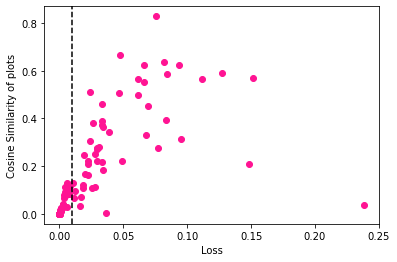

In [25]:
plt.scatter(loss,cos_sim.numpy(),color='deeppink')

plt.xlabel('Loss')
plt.ylabel('Cosine Similarity of plots')

ylim = plt.ylim()
plt.plot([0.01]*2,ylim,'k--')
plt.ylim(ylim)

In [26]:
loss.mean(axis=-1) 

tensor(0.0277)

Interesting to follow-up on, what's up w/ this point that has small loss and big cosine similarity?

**Guess:** This is an example that has very closely overlapping pixels :)

In [27]:
torch.argmax( ((loss.mean(axis=-1) < .1) & (cos_sim > 0.8)).float() )

tensor(56)

In [28]:
n_iter =  m.n_iter
nPixels = resolution[0]

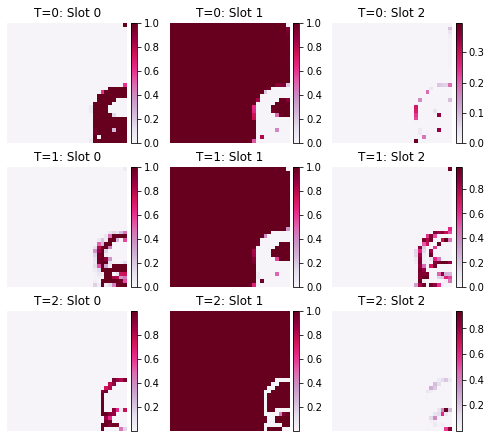

In [29]:
iEvt = 42

fig, axs = plt.subplots(n_iter+1,k_slots,figsize=(2.75*k_slots,2.5*(n_iter+1)))

for i, (ax_i, q) in enumerate(zip(axs, queries)):

    with torch.no_grad():
        att = m.attention_and_weights(m.queryN(q),encoded_data)[0]
    
    att_img = att[iEvt].reshape(k_slots,nPixels,nPixels)

    for j, (ax, img) in enumerate(zip(ax_i,att_img)):

        im = ax.imshow(img,cmap='PuRd')#,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(f'T={i}: Slot {j}')

        ax.axis('off')

**How does the loss change from iteration to iteration?**

Text(0.5, 1.0, 'Loss calculated by the slot assignment at the final step')

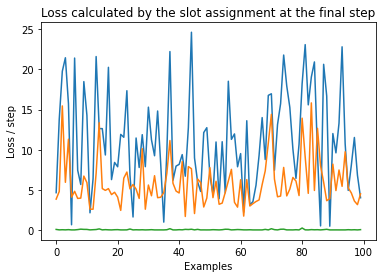

In [30]:
for i,li in enumerate(loss_per_iter):
    plt.plot(li.numpy(),label=f'T={i} step of SA')
    
plt.xlabel('Examples')
plt.ylabel('Loss / step')
plt.title('Loss calculated by the slot assignment at the final step')

In [31]:
cmap =mlp.colorbar.cm.get_cmap('turbo')

(-1.0, 100.0)

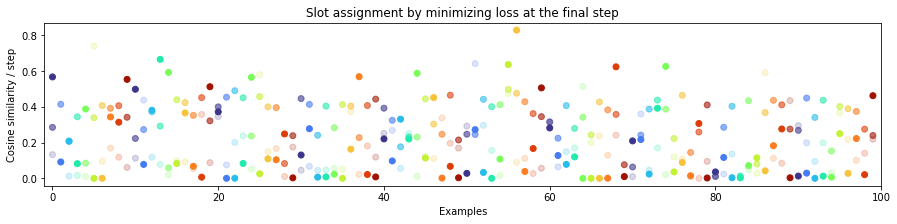

In [32]:
plt.figure(figsize=(15,3))

for i,cos_sim_i in enumerate( cos_sim_slot_iter ):
     
    xx = np.arange(bs)
    plt.scatter(xx,cos_sim_i.numpy(),color=cmap(0.1 * (xx%10)+.05),alpha=.2+i*0.4,
                label=f'T={i} step of SA')
    
plt.xlabel('Examples')
plt.ylabel('Cosine similarity / step')
plt.title('Slot assignment by minimizing loss at the final step')

plt.xlim(-1,bs)

Interesting... usually going in ~ equally sized steps.

**Follow-up** Change the step size in the GRU to take bigger steps at the beginning and smaller steps at the end.


Actually, one I added the `alpha` transparencies, this plot became harder to unpack... so I'll break it down by successful and unsuccessful examples.


In [33]:
loss.mean()

tensor(0.0277)

49
51
33


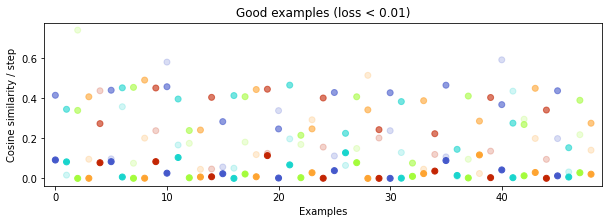

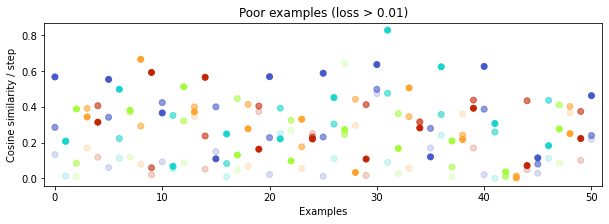

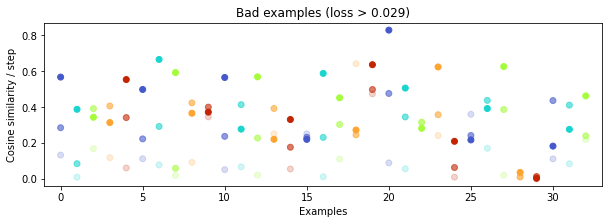

In [34]:
for mi, title in zip([loss < 0.01, loss > 0.01, loss > 0.029],
                       ['Good examples (loss < 0.01)','Poor examples (loss > 0.01)','Bad examples (loss > 0.029)']):

    plt.figure(figsize=(10,3))

    for i,cos_sim_i in enumerate( cos_sim_slot_iter ):

        xx = np.arange(torch.sum(mi))
        plt.scatter(xx,cos_sim_i[mi].numpy(),color=cmap(0.2 * (xx%5)+.1),alpha=.2+i*0.4,
                    label=f'T={i} step of SA')

    plt.xlabel('Examples')
    plt.ylabel('Cosine similarity / step')
    plt.title(title)

    plt.xlim(-1,len(xx))
    print(len(xx))

Text(0.5, 1.0, 'Slot assignment by minimizing loss at the final step')

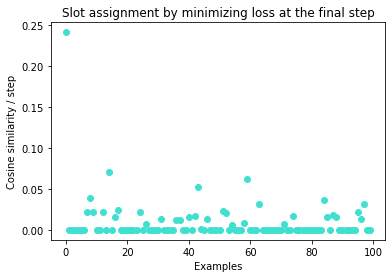

In [35]:
# The similarity of the labels doesn't change per example
plt.scatter(np.arange(bs),cos_sim_ring_iter[-1].numpy(),color='turquoise',label=f'T={i} step of SA')
    
plt.xlabel('Examples')
plt.ylabel('Cosine similarity / step')
plt.title('Slot assignment by minimizing loss at the final step')

**Take away:** This metric is generally low, but not guaranteed to be 0.

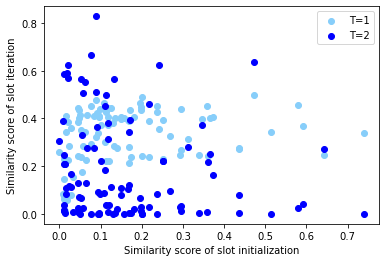

In [36]:
plt.scatter(cos_sim_slot_iter[0],cos_sim_slot_iter[1],
            color='lightskyblue',
            label='T=1')
plt.scatter(cos_sim_slot_iter[0],cos_sim_slot_iter[2],
            color='b',
            label='T=2')

plt.xlabel('Similarity score of slot initialization')
plt.ylabel('Similarity score of slot iteration')
plt.legend()

**Should we reinitialize, or train from scratch?**

**Plan:** Take my existing test set, and run 10 (or 100) times to see how the predictions change versus the query initialization.

In [37]:
from itertools import combinations

def cosSimAllSlots(att,k_slots):
    '''
    Compute the cosine similarity over all 
    possible combinations of slots
    '''
    cs =  torch.cat([torch.nn.CosineSimilarity()(att[:,i],att[:,j])[None,:] 
                               for i,j in combinations(range(k_slots),2)], axis=0)
    return cs.sum(axis=0)
    

In [38]:
loss_rand = []
chosen_slots_rand = []
cos_sim_slot_rand = []
cos_sim_all_rand  = []

for i in range(10):
    
    torch.manual_seed(torch_seed+i)
    
    with torch.no_grad():

        Nbatch = X.shape[0]

        # Get the image embedding
        encoded_data = m.encoder(X)

        # Initialize the queries
        queries = [ m.init_slots(Nbatch) ] # Shape (Nbatch, k_slots, query_dim)


        for i in range(m.n_iter):
            queries.append( m.iterate(queries[-1], encoded_data) )   

        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = m.attention_and_weights(m.queryN(queries[-1]),encoded_data)   

        # Get the indices that give the two slots
        pairwise_cost = all_losses(att, mask, Nbatch,k_slots,max_n_rings,resolution)
        indices = hungarian_matching(pairwise_cost)

        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

        '''
        Append info
        '''
        loss_rand.append( loss )
        chosen_slots_rand.append( slots_sorted )
        cos_sim_slot_rand.append( torch.nn.CosineSimilarity()(slots_sorted[:,0], slots_sorted[:,1]) )

        cos_sim_all_rand.append( cosSimAllSlots(att,k_slots) )
        
torch.manual_seed(torch_seed)         

**Check the loss across examples**

(-1.0, 100.0)

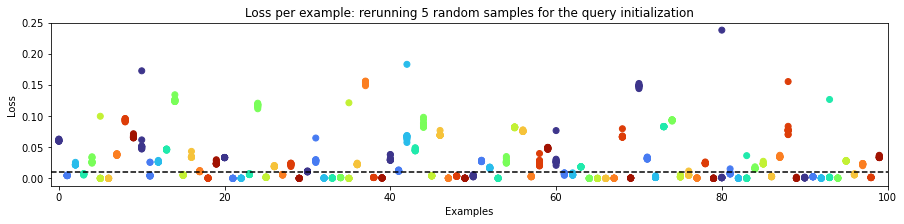

In [39]:
plt.figure(figsize=(15,3))

for i,cos_sim_i in enumerate( loss_rand ):
     
    xx = np.arange(bs)
    plt.scatter(xx,cos_sim_i.numpy(),color=cmap(0.1 * (xx%10)+.05))
    
plt.xlabel('Examples')
plt.ylabel('Loss')
plt.title('Loss per example: rerunning 5 random samples for the query initialization')

plt.plot([-1,bs],[.01]*2,'k--')
plt.xlim(-1,bs)

In [146]:
loss_rand[0].shape

torch.Size([100])

**Notes:**
- Some examples are very well classified
- Sometimes there is a _very big_ standard deviation in the predictions
- I can imagine this is making it much more difficult to make a stable NN prediction

**Question:** Is there a mode that I can run the algorithm in that doesn't have randomness in the evaluation time?

I can try just taking the randomness out by taking the mean? Or, I could _scale_ the $\sigma$ by $\frac{1}{10}$?

In [40]:
mu = m.slots_mu.expand(bs, k_slots, -1)
sigma = m.slots_logsigma.exp().expand(bs, k_slots, -1)

^ Yep... I could set to $\mu$, right?

In [43]:
loss_samples = torch.cat([li[None,:] for li in loss_rand],axis=0)
loss_samples.shape

torch.Size([10, 100])

In [157]:
loss.mean()

tensor(0.0285, grad_fn=<MeanBackward0>)

In [155]:
loss_samples.mean(axis=-1)

tensor([0.0277, 0.0290, 0.0254, 0.0259, 0.0264, 0.0262, 0.0250, 0.0249, 0.0251,
        0.0253])

Text(0.5, 0, 'Different query intializations')

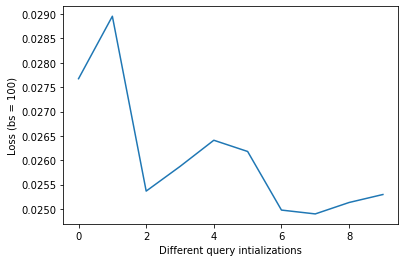

In [44]:
plt.plot(loss_samples.mean(axis=-1))
plt.ylabel('Loss (bs = 100)')
plt.xlabel('Different query intializations')

I mean... on average we're getting better.

But... this is kind of a big spread, right?

**What if there was a metric to pick the best initialization?**

In [45]:
vals, idx = torch.min(loss_samples,dim=0)

In [46]:
idx.shape

torch.Size([100])

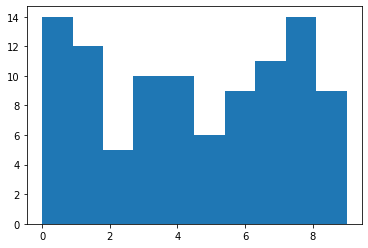

In [47]:
plt.hist(idx.numpy())
plt.show()

As expected, there's not an uniquely good initialization.

In [48]:
vals.shape

torch.Size([100])

In [49]:
vals.mean()

tensor(0.0238)

In [50]:
cs_all_samples = torch.cat([csi[None,:] for csi in cos_sim_all_rand],axis=0)
vals2, idx2 = torch.min(cs_all_samples,dim=0)

In [51]:
(idx==idx2).sum()

tensor(60)

In more than half the cases, what minimizes the loss will also minimize the cosine similarity

In [52]:
idx2.shape

torch.Size([100])

In [53]:
loss_samples.shape

torch.Size([10, 100])

In [54]:
loss_samples.T[np.arange(100),idx]

tensor([5.9846e-02, 4.4690e-03, 2.1517e-02, 5.3570e-03, 2.4430e-02, 7.2183e-05,
        6.3739e-05, 3.6943e-02, 9.0770e-02, 6.5118e-02, 4.7248e-02, 3.6211e-03,
        2.6214e-02, 4.5331e-02, 1.2349e-01, 4.9893e-03, 3.4088e-02, 1.0596e-02,
        3.5849e-04, 2.2892e-02, 3.3353e-02, 8.1126e-05, 2.0519e-04, 6.1168e-03,
        1.1186e-01, 1.5942e-03, 1.8790e-02, 5.1283e-03, 1.9134e-02, 8.2741e-05,
        1.0333e-02, 2.5744e-02, 4.2521e-04, 5.3949e-04, 1.2461e-03, 4.8485e-05,
        2.2043e-02, 1.4891e-01, 1.3403e-03, 6.5153e-04, 2.9002e-02, 1.1368e-02,
        5.7718e-02, 4.4184e-02, 8.2122e-02, 3.8250e-03, 6.9216e-02, 2.7968e-04,
        3.4036e-03, 2.3863e-04, 2.5339e-03, 2.6825e-02, 1.5916e-02, 7.0733e-05,
        2.4487e-02, 8.1035e-02, 7.5523e-02, 2.5383e-03, 2.0092e-02, 4.6695e-02,
        2.0987e-02, 4.9091e-03, 4.8555e-03, 1.8525e-02, 4.6892e-05, 3.2477e-05,
        3.3241e-05, 2.3746e-04, 6.6269e-02, 4.7526e-04, 1.4424e-01, 3.0799e-02,
        1.3862e-03, 8.2803e-02, 9.1994e-

In [55]:
vals

tensor([5.9846e-02, 4.4690e-03, 2.1517e-02, 5.3570e-03, 2.4430e-02, 7.2183e-05,
        6.3739e-05, 3.6943e-02, 9.0770e-02, 6.5118e-02, 4.7248e-02, 3.6211e-03,
        2.6214e-02, 4.5331e-02, 1.2349e-01, 4.9893e-03, 3.4088e-02, 1.0596e-02,
        3.5849e-04, 2.2892e-02, 3.3353e-02, 8.1126e-05, 2.0519e-04, 6.1168e-03,
        1.1186e-01, 1.5942e-03, 1.8790e-02, 5.1283e-03, 1.9134e-02, 8.2741e-05,
        1.0333e-02, 2.5744e-02, 4.2521e-04, 5.3949e-04, 1.2461e-03, 4.8485e-05,
        2.2043e-02, 1.4891e-01, 1.3403e-03, 6.5153e-04, 2.9002e-02, 1.1368e-02,
        5.7718e-02, 4.4184e-02, 8.2122e-02, 3.8250e-03, 6.9216e-02, 2.7968e-04,
        3.4036e-03, 2.3863e-04, 2.5339e-03, 2.6825e-02, 1.5916e-02, 7.0733e-05,
        2.4487e-02, 8.1035e-02, 7.5523e-02, 2.5383e-03, 2.0092e-02, 4.6695e-02,
        2.0987e-02, 4.9091e-03, 4.8555e-03, 1.8525e-02, 4.6892e-05, 3.2477e-05,
        3.3241e-05, 2.3746e-04, 6.6269e-02, 4.7526e-04, 1.4424e-01, 3.0799e-02,
        1.3862e-03, 8.2803e-02, 9.1994e-

^ Sanity checking that I know how the index syntax works :) 

In [56]:
# minimizes the loss by slot cosine similarity 
loss_samples.T[np.arange(100),idx2]

tensor([5.9846e-02, 4.4690e-03, 2.1517e-02, 5.3570e-03, 2.4430e-02, 7.2183e-05,
        6.3739e-05, 3.6943e-02, 9.0770e-02, 7.1738e-02, 1.7281e-01, 3.6211e-03,
        2.6394e-02, 4.5460e-02, 1.3436e-01, 4.9893e-03, 4.3432e-02, 1.1077e-02,
        3.5849e-04, 2.2892e-02, 3.3490e-02, 8.1126e-05, 2.0519e-04, 6.1168e-03,
        1.1186e-01, 1.5942e-03, 1.9089e-02, 5.1283e-03, 1.9134e-02, 8.2741e-05,
        1.0333e-02, 6.4865e-02, 4.2521e-04, 5.3949e-04, 1.2563e-03, 4.8485e-05,
        2.2135e-02, 1.5634e-01, 1.3403e-03, 6.5705e-04, 2.9002e-02, 1.1368e-02,
        1.8322e-01, 4.4184e-02, 9.8149e-02, 3.8250e-03, 6.9629e-02, 2.7968e-04,
        3.4036e-03, 2.5219e-04, 2.5515e-03, 2.6825e-02, 1.7689e-02, 7.0733e-05,
        3.5122e-02, 8.1978e-02, 7.5565e-02, 2.5383e-03, 2.8359e-02, 4.9526e-02,
        2.0987e-02, 4.9091e-03, 4.8555e-03, 1.8576e-02, 4.6892e-05, 3.2477e-05,
        3.3241e-05, 2.3746e-04, 6.6982e-02, 4.7765e-04, 1.5249e-01, 3.0799e-02,
        1.3862e-03, 8.3485e-02, 9.4111e-

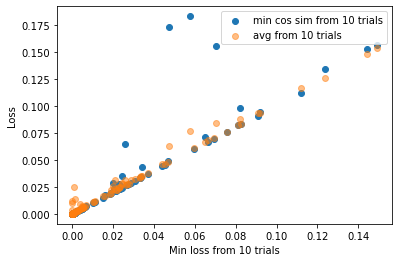

In [57]:
# plt.figure(figsize=(3,3))
plt.scatter(vals,loss_samples.T[np.arange(100),idx2], label='min cos sim from 10 trials')
plt.scatter(vals,loss_samples.mean(dim=0),alpha=0.5, label='avg from 10 trials')
plt.xlabel('Min loss from 10 trials')
plt.ylabel('Loss')
plt.legend()

- Ok, for cases where the min loss is high, there will be cases where the cosine similarity is worse than taking the average
- But if the min loss is lower, then the cosine similarity will look not as great (and I think these are the cases that I was wanting to avoid).

Text(0.5, 0, 'Different query intializations')

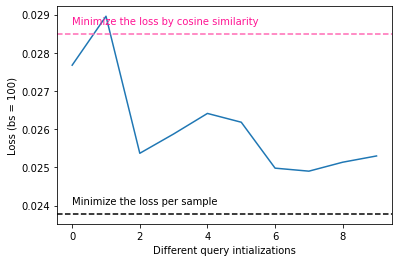

In [58]:
plt.plot(loss_samples.mean(axis=-1))

loss_min = vals.mean().numpy()
loss_cs = loss_samples.T[np.arange(100),idx2].mean().numpy()

xlim = plt.xlim()
plt.plot(xlim,loss_min*[1,1],'k--')
plt.plot(xlim,loss_cs*[1,1],'hotpink',ls='--')
plt.xlim(xlim)

ax = plt.gca()
eps = .0002
plt.text(0,loss_min+eps,'Minimize the loss per sample',va='bottom')
plt.text(0,loss_cs+eps,'Minimize the loss by cosine similarity',va='bottom',color='deeppink')

plt.ylabel('Loss (bs = 100)')
plt.xlabel('Different query intializations')

**Question:** How would the gradients change if we were able to do something like this?

Qualitatively, it feels like this is doing something that I like b/c we're choosing the loss that has very close to what was the _best_ guess for the initialization (for this training set).

In [59]:
with torch.no_grad():
    print(len(m(X)))

3


In [60]:
# Step 1: Get the gradients from these 10 initializaitons
for i in range(10):
    
    torch.manual_seed(torch_seed+i)
    
    att = m(X)[1]

    # Get the indices that give the two slots
    with torch.no_grad():
        pairwise_cost = all_losses(att,mask,bs,k_slots,max_n_rings,resolution)
        indices = hungarian_matching(pairwise_cost)

    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    # Calculate the loss
    loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    loss.mean().backward()
    
    break
    
torch.manual_seed(torch_seed)         


In [61]:
sum([np.prod(p.shape) for p in m.parameters()])

117840

In [62]:
mp = []
grads_0 = []

for p in m.parameters():
    mp.append(p.flatten())
    grads_0.append(p.grad.flatten())
    
grads_0 = torch.cat(grads_0)
mp = torch.cat(mp)

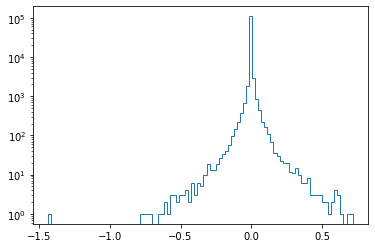

In [63]:
plt.hist(grads_0.numpy(),100,log=True,histtype='step')
plt.show()

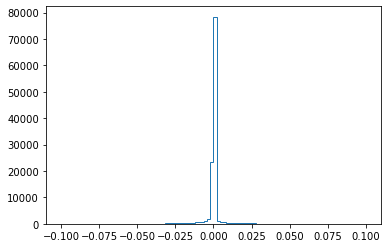

In [64]:
plt.hist(grads_0.numpy(),100,(-.1,.1),histtype='step')
plt.show()

**Q:** Is this a sparse network, or just sparse gradients?

**Another Q:** Is this indicating we're in a vanishing gradients situation?

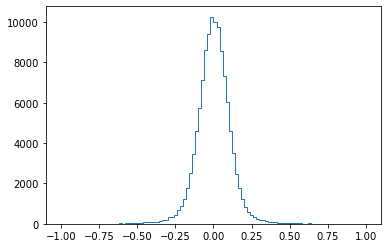

In [65]:
plt.hist(mp.detach().numpy(),100,(-1,1),histtype='step')
plt.show()

Yeah, the gradients aren't as strongly peaked at 0, so it does seem to be a vanishing gradients problem to me?

Weren't GRUs supposed to amelioriate this?

I feel like it might be _most interesting_ if I were able to choose the best config just by looking at the final slots.

In [66]:
slots_sorted.shape

torch.Size([100, 2, 1024])

In [67]:
att.shape

torch.Size([100, 3, 1024])

In [68]:
with torch.no_grad():
    cos_sim = torch.nn.CosineSimilarity()(slots_sorted[:,0],slots_sorted[:,1])

In [69]:
from itertools import combinations

In [70]:
for i,j in combinations(range(k_slots),2):
    print(i,j)

0 1
0 2
1 2


In [71]:
with torch.no_grad():
    cos_sim_all_slots = torch.cat([torch.nn.CosineSimilarity()(att[:,i],att[:,j])[None,:] 
                                   for i,j in combinations(range(k_slots),2)], axis=0)

In [72]:
cos_sim_all_slots.shape

torch.Size([3, 100])

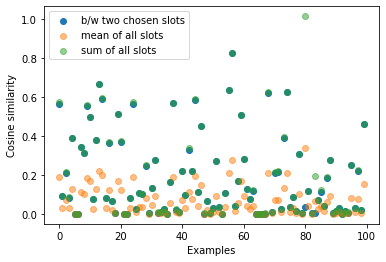

In [73]:
plt.scatter(np.arange(bs),cos_sim.numpy(),label='b/w two chosen slots')
plt.scatter(np.arange(bs),cos_sim_all_slots.mean(axis=0).numpy(),alpha=.5,label='mean of all slots')
plt.scatter(np.arange(bs),cos_sim_all_slots.sum(axis=0).numpy(),alpha=.5,label='sum of all slots')

plt.xlabel('Examples')
plt.ylabel('Cosine similarity')
plt.legend()
plt.show()

OK, nice the sum of all the cosine simiarities is a good proxy for the cosine similarity difference between the "chosen slots".

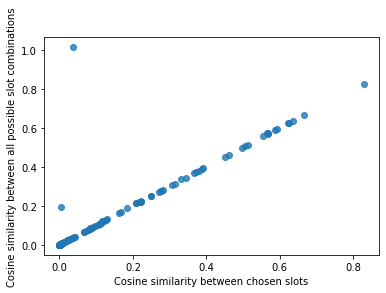

In [74]:
plt.scatter(cos_sim.numpy(),
            cos_sim_all_slots.sum(axis=0).numpy(),
            alpha=.8,label='sum of all slots')

plt.xlabel('Examples')
plt.xlabel('Cosine similarity between chosen slots')
plt.ylabel('Cosine similarity between all possible slot combinations')

plt.show()

**Important note:** This will be a _bad metric_ as soon as we have more than one background slot!

But, I think it would be a fine idea to just add an "occupied slot" loss, and then we can do the min over the occupied slots.

## Choose init by minimizing the cosine similarity

(I ended up just editting the notebook above.)

**How to implement?**

- I think the _best_ way would be to extend the model class to take 10 iterations, and then choose the average
- Oh, perhaps this might be easiest with renaming my forward() function to be smth else and then letting the _new_ forward function do the minimization over iterations?


In [75]:
class SlotAttentionReInit(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 learn_init=False,
                 query_dim=32, 
                 n_iter=2,
                 softmax_T='defaultx10',
                 pixel_mult=1,
                 pos_inpts=False,
                 device='cpu',
                 n_retarts=1
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - n_iter (default  2): Number of slot attention steps to apply (defualt 2)
        - T (str): Softmax temperature for scaling the logits 
            Needs to be one of 3 options:
            * default: 1/sqrt(query_dim)
            * defaultx10: 1/sqrt(query_dim)*10 (from LH WTFAE nb)
            * 1/D: 1/query_dim, as suggested by muTransfer 2203.03466
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution

        self.device=device
        
        assert softmax_T in ['default','defaultx10','1/D'] 
        if softmax_T=='default':
            self.softmax_T = 1/np.sqrt(query_dim)
        elif softmax_T=='defaultx10':
            self.softmax_T = 10/np.sqrt(query_dim)
        elif softmax_T=='1/D':
            self.softmax_T = 1/query_dim
        else:
            print(f'Softmax temperature {T} not supported')
            raise SyntaxError
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        input_dim = 5 if pos_inpts else 1 # whether or not to include the pixels w/ the input
        
        kwargs = { 'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }

        cnn_layers = [torch.nn.Conv2d(input_dim,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            '''
            22.08.2023 Silly mistake, I didn't include a ReLU() after the last CNN filter 
            for first exps. This `final_cnn_relu` flag is a hack for bkwds compatibility.
            '''
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
          
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device, pixel_mult)
        
        if pos_inpts:
            self.process_data = lambda X: \
                torch.cat([X,
                torch.tile(self.posEnc.grid.permute(0,3,1,2), [X.shape[0],1,1,1])],dim=1)
        else:
            self.process_data = lambda X: X

        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )

        if learn_init:
            self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
            self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
            init.xavier_uniform_(self.slots_logsigma)

            self.init_slots = self.SA_init_slots

        else:
            self.init_slots = self.LH_init_slots

    def SA_init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        return mu + sigma * torch.randn(mu.shape).to(self.device)

    def LH_init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(self.device)
        
        mu = torch.zeros(1,1,self.query_dim).to(self.device)
        logsigma = torch.zeros(1,1,self.query_dim).to(self.device)
        
        return mu + noise*logsigma.exp()
    
    def encoder(self,data):

        # If pos_inpts was passed at initialization, concatenate the grid
        encoded_data = self.process_data(data)

        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(encoded_data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1) 

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        # att, wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def single_init(self, encoded_data):

        # This is fine, I'll just save the gradients from the last step of the initialization
        self.gradients = []
    
        # Initialize the queries
        Nbatch = encoded_data.shape[0]
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att
    
    def forward(self, data, seed_list):
        
        bs = data.shape[0]
        encoded_data = self.encoder(data)
        
        queries_s = []
        att_s     = []
        cs_all_s  = []
        
        for seed in seed_list:
        
            # Set the random number generator
            torch.manual_seed(seed)
            
            # Get the queries
            queries, att = self.single_init(encoded_data)
    
            queries_s.append(queries)
            att_s.append(att)
            with torch.no_grad():
                cs_all_s.append(cosSimAllSlots(att,self.k_slots))
        
        with torch.no_grad():
            # Return the query vector that minimizes the cosine similarity
            cs_all_s = torch.cat([csi[None,:] for csi in cs_all_s],axis=0)
            vals2, idx2 = torch.min(cs_all_samples,dim=0)
                
        queries_s = torch.cat([qi[None,:] for qi in queries_s],axis=0)
        att_s = torch.cat([ai[None,:] for ai in att_s],axis=0)
                
        queries_final = torch.permute(queries_s,(1,0,2,3))[np.arange(bs),idx2]
        att_final = torch.permute(att_s,(1,0,2,3))[np.arange(bs),idx2]

        # Returning None b/c I was never using the weights at the end of this anyways
        return queries_final, att_final, None

In [76]:
m2 = SlotAttentionReInit(n_retarts=10,**hps)
m2.load_state_dict(torch.load(weightPath,map_location=device))

<All keys matched successfully>

**Nice!** Let's sanity check that this _works_

In [159]:
torch_seed

29082023

In [77]:
queries, att, _ = m2(X,torch_seed+np.arange(10))

In [78]:
with torch.no_grad():
    pairwise_cost = all_losses(att,mask,bs,k_slots,max_n_rings,resolution)
    indices = hungarian_matching(pairwise_cost)

# Apply the sorting to the predict
bis=torch.arange(bs).to(device)
indices=indices.to(device)

slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

# Calculate the loss
loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)

print(loss.mean().item())

0.028492383658885956


In [160]:
loss.shape

torch.Size([100, 1024])

In [144]:
loss_samples.shape

torch.Size([10, 100])

In [143]:
loss.shape

torch.Size([100, 1024])

Text(0.5, 0, 'Different query intializations')

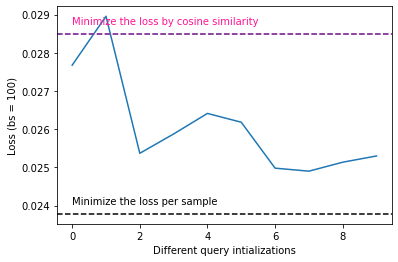

In [80]:
plt.plot(loss_samples.mean(axis=-1))

loss_min = vals.mean().numpy()
loss_cs = loss_samples.T[np.arange(100),idx2].mean().numpy()

xlim = plt.xlim()
plt.plot(xlim,loss_min*[1,1],'k--')
plt.plot(xlim,loss_cs*[1,1],'hotpink',ls='--')
plt.plot(xlim,loss.mean().item()*np.array([1,1]),'rebeccapurple',ls='--')
plt.xlim(xlim)

ax = plt.gca()
eps = .0002
plt.text(0,loss_min+eps,'Minimize the loss per sample',va='bottom')
plt.text(0,loss_cs+eps,'Minimize the loss by cosine similarity',va='bottom',color='deeppink')
# plt.text(10,loss.mean().item()+eps,'Implemented in model arch',va='bottom',color='rebeccapurple',ha='right')

plt.ylabel('Loss (bs = 100)')
plt.xlabel('Different query intializations')

**Fun follow-up:** Could I use a normalizing flow to learn the 128d query space and sample from it? 

- I could take a mostly trained model, and then train on these query vectors?
- I could also condition on the input data for drawing the samples from the flow?

**Parallel implementation:** I'm training this model in `Cosine-Similarity-Restarts`, but it's taking _a lot_ longer than it was before! (Like maybe even a factor of 100 longer.

My guess is that loops of loops are generally not such a great idea, so I'll try writing a parallel implementation for this!

In [81]:
def cosineSimilarityParallel(att):
    '''
    Inputs:
     - att: tensor shape (bs, n_restarts, k_slots, pixel_dim)
    '''
    k_slots = att.shape[2]
    cs =  torch.cat([torch.nn.CosineSimilarity(dim=-1)(att[:,:,i],att[:,:,j])[None,:] 
                               for i,j in combinations(range(k_slots),2)], axis=0)
    return cs.sum(axis=0)

In [82]:
class SlotAttentionParallel(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 learn_init=False,
                 query_dim=32, 
                 n_iter=2,
                 softmax_T='defaultx10',
                 pixel_mult=1,
                 pos_inpts=False,
                 device='cpu',
                 n_retarts=1
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter
        self.n_retarts = n_retarts
        
        self.resolution = resolution

        self.device=device
        
        self.softmax_T = 1/np.sqrt(query_dim)

        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        input_dim = 5 if pos_inpts else 1 # whether or not to include the pixels w/ the input
        
        kwargs = { 'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }

        cnn_layers = [torch.nn.Conv2d(input_dim,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            '''
            22.08.2023 Silly mistake, I didn't include a ReLU() after the last CNN filter 
            for first exps. This `final_cnn_relu` flag is a hack for bkwds compatibility.
            '''
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
          
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device, pixel_mult)
        
        if pos_inpts:
            self.process_data = lambda X: \
                torch.cat([X,
                torch.tile(self.posEnc.grid.permute(0,3,1,2), [X.shape[0],1,1,1])],dim=1)
        else:
            self.process_data = lambda X: X

        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        # Note -- I can simplify this later, but for now I 
        # need to do the reshaping differently, otherwise I can't 
        # start from a warm start
        mu = torch.tile(mu[:,None],dims=(1,self.n_retarts,1,1))
        sigma = torch.tile(sigma[:,None],dims=(1,self.n_retarts,1,1))
            
        return mu + sigma * torch.randn(mu.shape).to(self.device)
    
    def encoder(self,data):

        # If pos_inpts was passed at initialization, concatenate the grid
        encoded_data = self.process_data(data)

        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(encoded_data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
        
    def attention_and_weights(self,queries,encoded_data):
        
        keys = self.toK(encoded_data)
        logits = torch.einsum('b...se,bde->b...sd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 2) 

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        # att, wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('b...sd,bde->b...se',wts,vals) # bs, n_restarts n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim))

        return updates.reshape(queries.shape)
        
    
    def forward(self, data):
        
        # Get the encoded view of the image
        encoded_data = self.encoder(data)
        
        Nbatch = encoded_data.shape[0]
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        cs = cosineSimilarityParallel(att)
        
        i_b = np.arange(Nbatch)
        i_s = torch.argmin(cs,dim=1)
            
        return queries[i_b,i_s], att[i_b,i_s], wts[i_b,i_s] 

In [83]:
m3 = SlotAttentionParallel(n_retarts=10,**hps)
m3.load_state_dict(torch.load(weightPath,map_location=device),strict=False)

<All keys matched successfully>

**Note on broadcasting with `torch.einsum`:**

`The dimensions labeled with the same subscript must be broadcastable, that is, their size must either match or be 1.`

In [84]:
q,att,w = m3(X)

For each example, calculate the init that minimizes the cosine similarity b/w the slots

In [85]:
q.shape

torch.Size([100, 3, 128])

In [86]:
att.shape

torch.Size([100, 3, 1024])

In [87]:
w.shape

torch.Size([100, 3, 1024])

In [88]:
from train import train

In [89]:
opt = cd['opt']
opt['Ntrain'] = 6

In [90]:
figDir = 'code/figures/test'
modelDir = 'code/models/test'

# os.mkdir(figDir)
# os.mkdir(modelDir)

Training model with 3 slots on 2rings


/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 0.017885461 , lr 0.0


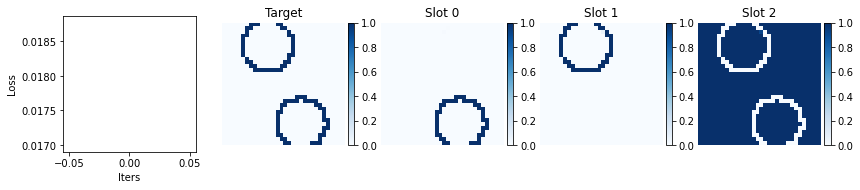

iter 5 , loss 0.022901677 , lr 2.749809391131423e-07


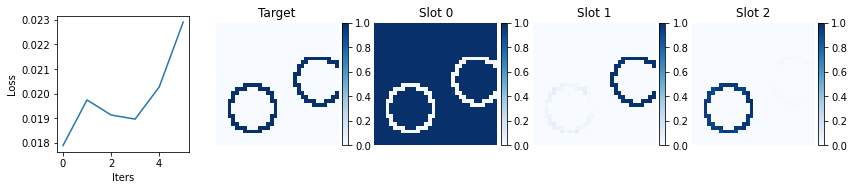

(SlotAttentionParallel(
   (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
   (queryN): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (toK): Linear(in_features=16, out_features=128, bias=True)
   (toV): Linear(in_features=16, out_features=128, bias=True)
   (gru): GRUCell(128, 128)
   (CNN_encoder): Sequential(
     (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): ReLU()
     (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (3): ReLU()
     (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   )
   (posEnc): SoftPositionalEmbed(
     (dense): Linear(in_features=4, out_features=16, bias=True)
   )
   (init_mlp): Sequential(
     (0): Linear(in_features=16, out_features=16, bias=True)
     (1): ReLU()
     (2): Linear(in_features=16, out_features=16, bias=True)
   )
 ),
 [0.017885461449623108,
  0.01974165067076683,
  0.01912860944867134,
  0.018961966037750244,
  0.020264562219381332,


In [91]:
train(m3,kwargs=kwargs,**opt,plot_every=5,figDir=figDir,modelDir=modelDir)

## Request from Lukas:

What does the cosine similarity of the pixels in the _same ring_ look like.

<img src="cluster-similarity.png" style="height:250px" />

We're trying to diagnose whether we need a better embedding, or if we need to improve the GRU queries convergence.

**Note:** This does _not_ depend on the query initialization... only on the CNN encoder and the keys (linear projection vector for each pixel to map into the query space).


In [92]:
X.shape

torch.Size([100, 1, 32, 32])

In [93]:
encoded_data.shape

torch.Size([100, 1024, 16])

In [94]:
m.toK

Linear(in_features=16, out_features=128, bias=True)

In [95]:
with torch.no_grad():
    encoded_data = m.encoder(X)
    
    keys = m.toK(encoded_data)

In [96]:
encoded_data.shape

torch.Size([100, 1024, 16])

In [97]:
keys.shape

torch.Size([100, 1024, 128])

Which pixels live in which ring belongs in the truth labels, `mask`.

In [98]:
mask.shape

torch.Size([100, 2, 32, 32])

In [99]:
flat_mask = mask.reshape(100,2,np.prod(resolution))
flat_mask.shape

torch.Size([100, 2, 1024])

In [100]:
torch.max((flat_mask[:,0]>0).sum(dim=1))

tensor(58)

In [101]:
torch.max((flat_mask[:,1]>0).sum(dim=1))

tensor(58)

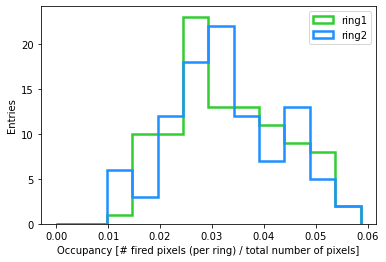

In [102]:
img_dim = np.prod(resolution)
mf = 60
nb = mf//5

plt.hist((flat_mask[:,0]>0).sum(dim=1).numpy()/img_dim,
         nb,(0,mf/img_dim),color='limegreen',histtype='step',
         lw=2.5,label='ring1')
plt.hist((flat_mask[:,1]>0).sum(dim=1).numpy()/img_dim,
         nb,(0,mf/img_dim),color='dodgerblue',histtype='step',
         lw=2.5,label='ring2')

plt.xlabel('Occupancy [# fired pixels (per ring) / total number of pixels]')
plt.ylabel('Entries')
plt.legend()
plt.show()

So each pixel contributes with it's weight given by `mask` in the sum for the centroid calculation.

In [103]:
flat_mask.shape

torch.Size([100, 2, 1024])

In [104]:
def get_mean_std(X,flat_mask):
    '''
    Computes mean of the slots, in a vectorized way
    '''
    
    mu  = torch.sum(X.unsqueeze(1) * flat_mask.unsqueeze(-1),dim=2) 
    mu /= torch.sum(flat_mask,dim=2,keepdim=True)
    
    var  = torch.sum(torch.pow(X.unsqueeze(1)-mu.unsqueeze(2),2) * flat_mask.unsqueeze(-1),dim=2) 
    var /= torch.sum(flat_mask,dim=2,keepdim=True)
    
    return mu, torch.sqrt(var)


In [105]:
mu_k, std_k = get_mean_std(keys,flat_mask)
mu_d, std_d = get_mean_std(encoded_data,flat_mask)

In [106]:
mu_k.shape

torch.Size([100, 2, 128])

In [107]:
cs_k =torch.nn.CosineSimilarity()(mu_k[:,0],mu_k[:,1])
cs_d =torch.nn.CosineSimilarity()(mu_d[:,0],mu_d[:,1])

In [ ]:
cs_k

tensor([1.0000, 0.9999, 0.9999, 0.9998, 1.0000, 0.9987, 0.9994, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9997,
        0.9996, 1.0000, 1.0000, 0.9989, 0.9990, 0.9998, 1.0000, 0.9998, 0.9998,
        0.9999, 0.9999, 0.9993, 0.9999, 1.0000, 0.9994, 0.9996, 0.9997, 0.9991,
        0.9999, 1.0000, 0.9997, 0.9997, 0.9999, 0.9998, 1.0000, 0.9999, 1.0000,
        0.9999, 1.0000, 0.9994, 0.9998, 0.9993, 0.9997, 0.9999, 0.9997, 0.9989,
        0.9999, 1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 0.9999, 0.9997, 0.9999,
        0.9999, 0.9978, 0.9988, 0.9991, 0.9994, 1.0000, 0.9997, 1.0000, 0.9999,
        0.9998, 1.0000, 1.0000, 0.9998, 0.9999, 0.9997, 1.0000, 0.9995, 0.9997,
        0.9998, 0.9994, 0.9994, 0.9999, 0.9998, 0.9994, 0.9999, 0.9999, 0.9993,
        0.9994, 0.9997, 0.9993, 0.9997, 0.9995, 1.0000, 0.9996, 0.9999, 0.9995,
        1.0000])

In [ ]:
cs_d

tensor([1.0000, 0.9990, 0.9994, 0.9975, 0.9996, 0.9861, 0.9933, 0.9997, 0.9998,
        0.9999, 0.9997, 0.9975, 0.9997, 0.9999, 1.0000, 0.9990, 0.9997, 0.9973,
        0.9959, 0.9999, 0.9997, 0.9883, 0.9898, 0.9981, 1.0000, 0.9980, 0.9981,
        0.9986, 0.9994, 0.9924, 0.9987, 0.9996, 0.9941, 0.9956, 0.9973, 0.9900,
        0.9991, 1.0000, 0.9974, 0.9970, 0.9993, 0.9977, 1.0000, 0.9993, 0.9999,
        0.9987, 0.9999, 0.9939, 0.9979, 0.9921, 0.9968, 0.9994, 0.9970, 0.9878,
        0.9988, 1.0000, 1.0000, 0.9983, 0.9988, 0.9999, 0.9992, 0.9971, 0.9987,
        0.9986, 0.9768, 0.9871, 0.9910, 0.9939, 0.9999, 0.9964, 0.9998, 0.9993,
        0.9975, 0.9999, 1.0000, 0.9980, 0.9989, 0.9970, 0.9996, 0.9947, 0.9971,
        0.9980, 0.9940, 0.9936, 0.9987, 0.9977, 0.9936, 0.9990, 0.9993, 0.9929,
        0.9938, 0.9971, 0.9925, 0.9970, 0.9949, 0.9995, 0.9962, 0.9994, 0.9943,
        0.9998])

A lot of these are _super_ similar... that's not great! 

Text(0, 0.5, 'CS: CNN feature centroids (pixels in two rings)')

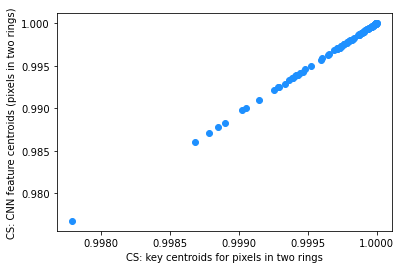

In [110]:
plt.scatter(cs_k,cs_d,color='dodgerblue')
plt.xlabel('CS: key centroids for pixels in two rings')
plt.ylabel('CS: CNN feature centroids (pixels in two rings)')

In [111]:
loss.shape

torch.Size([100, 1024])

In [112]:
loss_evt = loss.mean(axis=-1).detach().numpy()

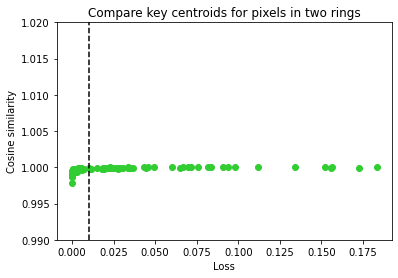

In [113]:
plt.scatter(loss_evt,
            cs_k.numpy(),color='limegreen')
plt.xlabel('Loss')
plt.ylabel('Cosine similarity')
ymin = .99
ymax = 1.02
plt.plot([.01]*2,[ymin,ymax],'k--')
plt.ylim(ymin,ymax)
plt.title('Compare key centroids for pixels in two rings')
plt.show()

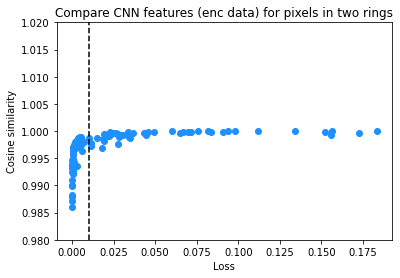

In [114]:
plt.scatter(loss_evt,cs_d.numpy(),color='dodgerblue')
plt.xlabel('Loss')
plt.ylabel('Cosine similarity')
ymin = .98
ymax = 1.02
plt.plot([.01]*2,[ymin,ymax],'k--')
plt.ylim(ymin,ymax)
plt.title('Compare CNN features (enc data) for pixels in two rings')
plt.show()

Let's look at the histogram

In [115]:
cs_allpix = torch.nn.CosineSimilarity(dim=3)(keys.unsqueeze(1),mu_k.unsqueeze(2))
cs_allpix.shape

torch.Size([100, 2, 1024])

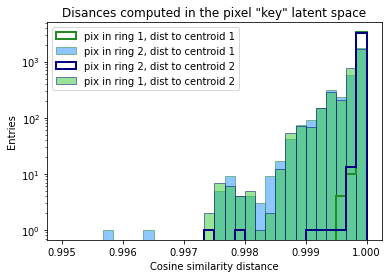

In [116]:
nb = 30
r = (.995,1)
log=True
alpha=.4

plt.hist((cs_allpix[:,0][flat_mask[:,0]>0]).numpy(),nb,r,
         label='pix in ring 1, dist to centroid 1',log=log,
         color='forestgreen',histtype='step',lw=2)

plt.hist((cs_allpix[:,0][flat_mask[:,1]>0]).numpy(),nb,r,
         label='pix in ring 2, dist to centroid 1',log=log,
         color='dodgerblue',ec='forestgreen',alpha=.5)

plt.hist((cs_allpix[:,1][flat_mask[:,1]>0]).numpy(),nb,r,
         label='pix in ring 2, dist to centroid 2',log=log,
         color='navy',histtype='step',lw=2)

plt.hist((cs_allpix[:,1][flat_mask[:,0]>0]).numpy(),nb,r,
         label='pix in ring 1, dist to centroid 2',log=log,
         color='limegreen',ec='navy',alpha=.5)

plt.xlabel('Cosine similarity distance')
plt.ylabel('Entries')

plt.legend()

plt.title('Disances computed in the pixel "key" latent space')

plt.show()

Break down by "working" and "not working" examples

In [117]:
np.sum(loss_evt < 0.001)

26

In [118]:
np.sum(loss_evt > 0.029)

29

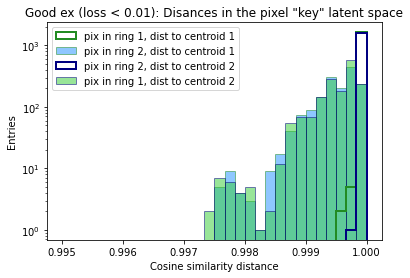

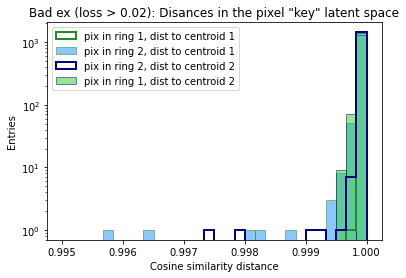

In [119]:
for mi,ti in zip([loss_evt < 0.01, loss_evt > 0.02],['Good ex (loss < 0.01)','Bad ex (loss > 0.02)']):

    plt.hist((cs_allpix[mi,0][flat_mask[mi,0]>0]).numpy(),nb,r,
             label='pix in ring 1, dist to centroid 1',log=log,
             color='forestgreen',histtype='step',lw=2)

    plt.hist((cs_allpix[mi,0][flat_mask[mi,1]>0]).numpy(),nb,r,
             label='pix in ring 2, dist to centroid 1',log=log,
             color='dodgerblue',ec='forestgreen',alpha=.5)

    plt.hist((cs_allpix[mi,1][flat_mask[mi,1]>0]).numpy(),nb,r,
             label='pix in ring 2, dist to centroid 2',log=log,
             color='navy',histtype='step',lw=2)

    plt.hist((cs_allpix[mi,1][flat_mask[mi,0]>0]).numpy(),nb,r,
             label='pix in ring 1, dist to centroid 2',log=log,
             color='limegreen',ec='navy',alpha=.5)

    plt.xlabel('Cosine similarity distance')
    plt.ylabel('Entries')

    plt.legend()

    plt.title(f'{ti}: Disances in the pixel "key" latent space')

    plt.show()

## Diagnostic 0: Just look at the rings

In [120]:
loss.shape

torch.Size([100, 1024])

In [121]:
np.sum(loss_evt < 0.01)

51

In [122]:
np.sum(loss_evt > 0.02)

41

In [123]:
mj = (loss_evt > 0.02)
bad_imgs = mask.sum(dim = 1)[mj]
bad_imgs.shape

torch.Size([41, 32, 32])

In [124]:
mi = loss_evt < 0.01
good_imgs = mask.sum(dim = 1)[mi]
good_imgs.shape

torch.Size([51, 32, 32])

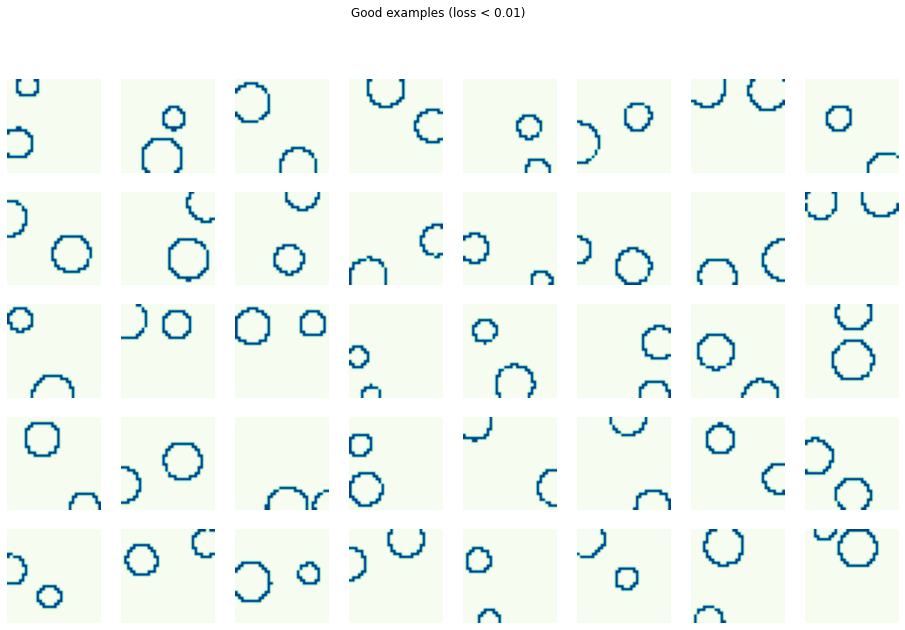

In [125]:
# Good exs
nrows = 5
ncols = 8
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        k = i * ncols + j 
        im = ax.imshow(good_imgs[k].numpy(),cmap='GnBu')

        ax.axis('off')
        # ax.set_title(0,0,f'evt={k}',transform=ax_ij.transAxes)
        
fig.suptitle('Good examples (loss < 0.01)',va='top')
plt.show()

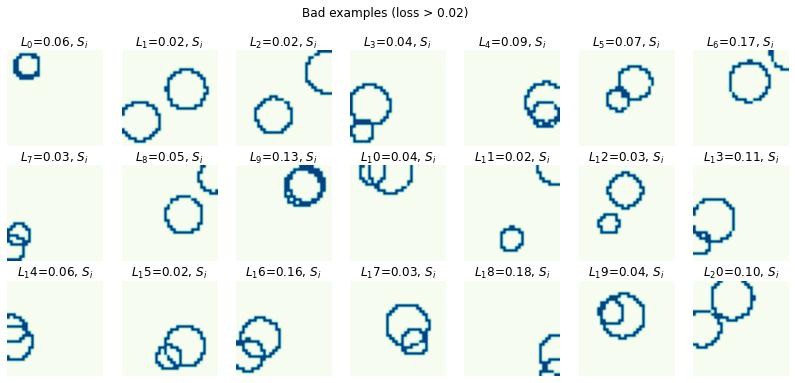

In [126]:
# Bad exs
nrows = 3
ncols = 7
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))

for i, ax_i in enumerate(axes):

    for j, ax in enumerate(ax_i):

        k = i * ncols + j 
        im = ax.imshow(bad_imgs[k].numpy(),cmap='GnBu')

        
        ax.axis('off')
        ax.set_title(f'$L_{k}$={loss_evt[mj][k]:.2f}, $S_i$',transform=ax.transAxes)
        
fig.suptitle('Bad examples (loss > 0.02)',va='top')
plt.show()

Right... let's remind ourselves what these looked like.

In [ ]:
bad

In [127]:
mask[mj].shape

torch.Size([41, 2, 32, 32])

In [128]:
torch.unique(bad_imgs[k])

tensor([0., 1.])

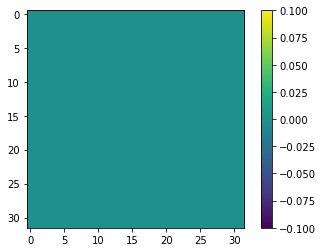

In [129]:
k=4
plt.imshow(bad_imgs[k] * np.log(np.where(bad_imgs[k]==0, 1, bad_imgs[k])))
plt.colorbar()

In [130]:
img = mask[mj][0]
img1,img2 = img

In [131]:
# plt.imshow(img2)

In [132]:
x = img * np.log(np.where(img==0, 1, img))
x.sum(dim=0).mean()

tensor(-0.0110)

In [133]:
loss_evt[mj][0]

0.059845585

In [134]:
entropy = mask * np.log(np.where(mask==0, 1, mask))
entropy = - entropy.sum(dim=1).mean(dim=[1,2])

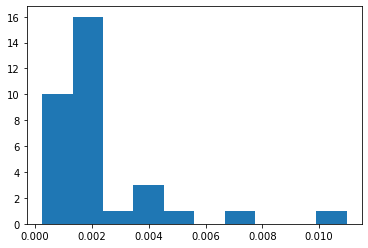

In [135]:
plt.hist(entropy[entropy>0].numpy())
plt.show()

In [136]:
loss_evt[entropy>0].mean()

0.05644551

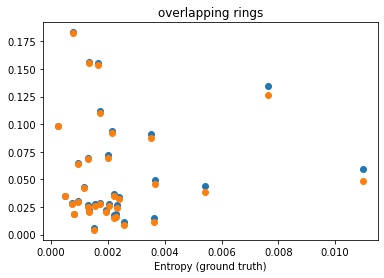

In [137]:
plt.scatter(entropy[entropy>0].numpy(),loss_evt[entropy>0],label='loss')
plt.scatter(entropy[entropy>0].numpy(),loss_evt[entropy>0]-entropy[entropy>0].numpy(),label='loss - entropy')
plt.title('overlapping rings')
plt.xlabel('Entropy (ground truth)')

plt.show()

In [138]:
(loss_evt[entropy>0]-entropy[entropy>0].numpy()).mean()

0.054125614

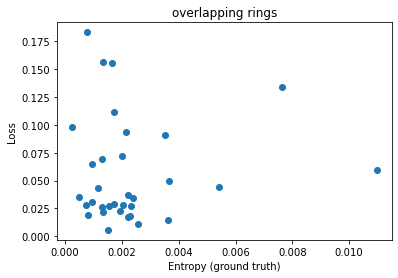

In [139]:
plt.scatter(entropy[entropy>0].numpy(),loss_evt[entropy>0])
plt.title('overlapping rings')
plt.xlabel('Entropy (ground truth)')
plt.ylabel('Loss')
plt.show()

**What does this crazy example 0 look like?**

In [173]:
from matplotlib.patches import Circle

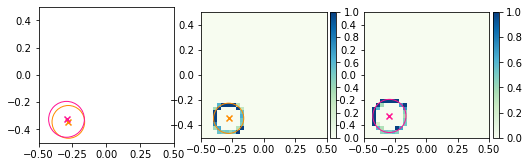

In [186]:
fig, axs = plt.subplots(1,max_n_rings+1,figsize=(2.75*(max_n_rings+1),2.5))

ax = axs[0]
# ax.axis('off')
extent = [-0.5, 0.5]*2
ax.set_xlim(extent[:2])
ax.set_ylim(extent[:2])

colors = ['darkorange','deeppink']
for yi,ci in zip(y[0],colors):

    ax.scatter(*yi[:2],marker='x',color=ci)
    circle = Circle(yi[:2],yi[2],fill=False,color=ci)
    ax.add_patch(circle)



for ax,img,yi,ci in zip(axs[1:],mask[0],y[0],colors):

    im = ax.imshow(img,cmap='GnBu',vmin=0,vmax=1,
                   extent=extent,origin='lower'
                  )
    # ax.set_title(title)
    # ax.axis('off')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    
    ax.scatter(*yi[:2],marker='x',color=ci)
    circle = Circle(yi[:2],yi[2],fill=False,color=ci)
    ax.add_patch(circle)

    
plt.show()

In [168]:
y.shape

torch.Size([100, 2, 3])

In [142]:
# with torch.no_grad():

#         queries, att, wts = m(X)

#         indices = hungarian_matching(att,mask,bs,k_slots,max_n_rings,resolution[0])

#         # Apply the sorting to the predict
#         bis=torch.arange(bs).to(device)
#         indices=indices.to(device)

#         slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

#         flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
#         rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

#         # Calculate the loss
#         loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1)

#     if return_mean:
#         return loss.mean().item()
#     else:
#         # just avg the pixel loss, but don't avg over the exs
#         return loss.mean(axis=-1)

In [ ]:
for imgs,li in zip(mask[mj],loss_evt[mj]):
    
    fig, axs = plt.subplots(1,k_slots+2,figsize=(2.75 * (k_slots * 2) ,2.5))
    
    imgs   = [mask] + [att[i] for i in range(k_slots)]
    titles = ['Target']+[f'Slot {i}' for i in range(k_slots)]
    
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img,cmap=cmap,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)

        ax.axis('off')


**Request from Steffan:** How does the model trained on _two rings_ do at isolating _one ring_?

**Setup:**  I think it's fine to just take model `m`, because the slot minimization metric doesn't really make a lot of sense here

In [ ]:
kwargs

In [ ]:
X0,y0,mask0 = make_batch(N_events=10,N_clusters=1,isRing=True)

In [ ]:
with torch.no_grad():
    att0 = m(X0)[1]

In [ ]:
att0[i].shape

In [ ]:
for i in range(10):

    fig, axs = plt.subplots(1,k_slots+1,figsize=(2.25 * (k_slots + 1) ,2))

    imgs  = [mask0[i,0].numpy()] 
    imgs += [att0[i,j].reshape(resolution).numpy() for j in range(k_slots)]
    titles = ['Target']+[f'Slot {i}' for i in range(k_slots)]

    for j,ax,img,title in zip(range(k_slots+1),axs,imgs, titles):

        im = ax.imshow(img,cmap='Oranges',vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        ax.axis('off')
    # break